In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim
import copy
import matplotlib.pyplot as plt

In [ ]:
batch_size=256
learning_rate=0.001
epochs=100

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_train, fmnist_val=torch.utils.data.random_split(fmnist_train, [50000, 10000])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
dataloader=dict()
dataloader["train"]=DataLoader(fmnist_train, batch_size, shuffle=True)
dataloader["val"]=DataLoader(fmnist_val, batch_size, shuffle=False)
dataloader["test"]=DataLoader(fmnist_test, batch_size, shuffle=False)

In [ ]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    self.encoder=nn.Sequential(
        nn.Linear(28*28, 400),
        nn.BatchNorm1d(400),
        nn.ReLU(),
        nn.Linear(400, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 100),
        nn.BatchNorm1d(100),
        nn.ReLU()
    )
    self.mu=nn.Linear(100,20)
    self.sigma=nn.Linear(100,20)
    self.decoder=nn.Sequential(
        nn.Linear(20, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 400),
        nn.BatchNorm1d(400),
        nn.ReLU(),
        nn.Linear(400, 784),
        nn.Sigmoid()
    )
  def reparameterize(self, mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std
  def forward(self, x):
    x=x.reshape(-1, 28*28)
    encoded=self.encoder(x)
    mean=self.mu(encoded)
    var=self.sigma(encoded)
    z=self.reparameterize(mean,var)
    out=self.decoder(z).reshape(-1, 1, 28, 28)
    return out, mean, var

In [ ]:
model=VAE().to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_model=copy.deepcopy(model.state_dict())
best_eval_loss=float('inf')
train_history=[]
eval_history=[]
for epoch in range(epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    running_loss = 0.0
    for x,y in dataloader[phase]:
      x=x.to(device)
      y=y.to(device)
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=='train'):
        output, mean, var=model(x)
        loss=criterion(output, x)
        if phase=='train':
          loss.backward()
          optimizer.step()
      running_loss+=loss.item()
      epoch_loss = running_loss / len(dataloader[phase].dataset)

    if phase=='train':
      print(f'Epoch {epoch}/{epochs-1}')
      print(f'train loss: {epoch_loss}')
      train_history.append(epoch_loss)
    else:
      print(f'eval loss: {epoch_loss}')
      eval_history.append(epoch_loss)
      if epoch_loss<best_eval_loss:
        best_eval_loss=epoch_loss
        best_model=copy.deepcopy(model.state_dict())

print(f'Best Validation Loss: {best_eval_loss}')

Epoch 0/99
train loss: 0.00014203492682427168
eval loss: 9.119478035718203e-05
Epoch 1/99
train loss: 8.21030743792653e-05
eval loss: 7.653216142207385e-05
Epoch 2/99
train loss: 7.01130835339427e-05
eval loss: 6.748428680002689e-05
Epoch 3/99
train loss: 6.316291997209192e-05
eval loss: 6.167250880971551e-05
Epoch 4/99
train loss: 5.900367109104991e-05
eval loss: 5.917392782866955e-05
Epoch 5/99
train loss: 5.5811384581029415e-05
eval loss: 5.545690273866058e-05
Epoch 6/99
train loss: 5.3258388601243494e-05
eval loss: 5.356639344245195e-05
Epoch 7/99
train loss: 5.144071547314524e-05
eval loss: 5.1695808954536915e-05
Epoch 8/99
train loss: 4.986612053588033e-05
eval loss: 4.9344345554709434e-05
Epoch 9/99
train loss: 4.8186655398458245e-05
eval loss: 4.895054567605257e-05
Epoch 10/99
train loss: 4.7101771105080845e-05
eval loss: 4.7667034063488246e-05
Epoch 11/99
train loss: 4.623456759378314e-05
eval loss: 4.644585447385907e-05
Epoch 12/99
train loss: 4.546501901000738e-05
eval loss:

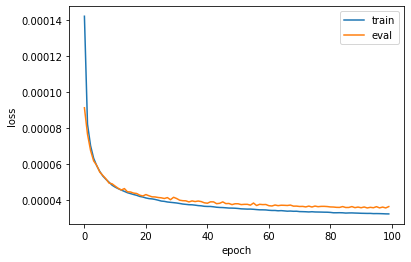

In [ ]:
plt.plot(train_history, label="train")
plt.plot(eval_history, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(best_model)
with torch.no_grad():
  for x,y in dataloader["test"]:
    x=x.to(device)
    y=y.to(device)

    output,mean,var=model(x)
    loss=criterion(output, x)

  print(loss.item())

0.015463478863239288


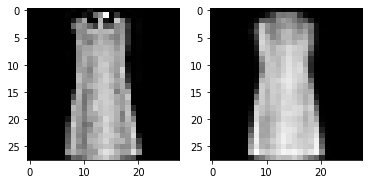

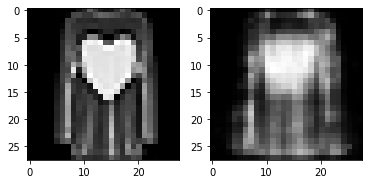

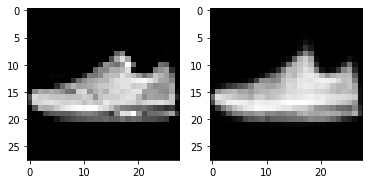

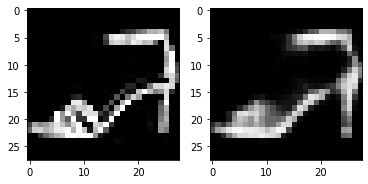

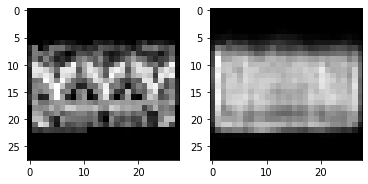

In [ ]:
out_img = torch.squeeze(output.cpu().data)
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()